<h1>Transfer Learning - DenseNet121</h1>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)

In [ ]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/BTech_Project/preprocessed_v2/Training'
test_dir = '/content/drive/MyDrive/Colab Notebooks/BTech_Project/preprocessed_v2/Testing'

In [ ]:
#augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.15
)

#no augmentation for validation and testing sets
val_datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.15)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

#load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

#load test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 4687 images belonging to 4 classes.
Found 826 images belonging to 4 classes.
Found 1212 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.regularizers import l2

#load the pre-trained DenseNet121 base model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)

#combine base model and custom layers into one model
model = Model(inputs=base_model.input, outputs=x)

#freezing the base model layers initially
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
#callbacks to adjust learning rate and prevent overfitting
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#train the initial model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[reduce_lr, early_stopping]
)

model.save('DenseNet121_initial.keras')

Epoch 1/15
147/147 [==============================] - 1129s 8s/step - loss: 1.8603 - accuracy: 0.6047 - val_loss: 1.3539 - val_accuracy: 0.7736 - lr: 1.0000e-04
Epoch 2/15
147/147 [==============================] - 118s 799ms/step - loss: 1.1975 - accuracy: 0.7967 - val_loss: 1.1587 - val_accuracy: 0.7809 - lr: 1.0000e-04
Epoch 3/15
147/147 [==============================] - 117s 795ms/step - loss: 1.0137 - accuracy: 0.8248 - val_loss: 1.0792 - val_accuracy: 0.7688 - lr: 1.0000e-04
Epoch 4/15
147/147 [==============================] - 115s 782ms/step - loss: 0.9141 - accuracy: 0.8489 - val_loss: 0.9925 - val_accuracy: 0.8002 - lr: 1.0000e-04
Epoch 5/15
147/147 [==============================] - 112s 763ms/step - loss: 0.8583 - accuracy: 0.8539 - val_loss: 0.9386 - val_accuracy: 0.8172 - lr: 1.0000e-04
Epoch 6/15
147/147 [==============================] - 114s 774ms/step - loss: 0.8120 - accuracy: 0.8577 - val_loss: 0.8963 - val_accuracy: 0.8123 - lr: 1.0000e-04
Epoch 7/15
147/147 [====

In [ ]:
#unfreeze the last layers of the base model for fine-tuning
for layer in base_model.layers[-70:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

#fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[reduce_lr, early_stopping]
)

model.save('DenseNet121_finetuned.keras')

Epoch 1/15
147/147 [==============================] - 133s 838ms/step - loss: 0.8720 - accuracy: 0.8076 - val_loss: 0.8219 - val_accuracy: 0.8220 - lr: 1.0000e-05
Epoch 2/15
147/147 [==============================] - 122s 828ms/step - loss: 0.6832 - accuracy: 0.8603 - val_loss: 0.7868 - val_accuracy: 0.8462 - lr: 1.0000e-05
Epoch 3/15
147/147 [==============================] - 121s 822ms/step - loss: 0.6516 - accuracy: 0.8733 - val_loss: 0.7944 - val_accuracy: 0.8354 - lr: 1.0000e-05
Epoch 4/15
147/147 [==============================] - 119s 807ms/step - loss: 0.6206 - accuracy: 0.8897 - val_loss: 0.7560 - val_accuracy: 0.8499 - lr: 1.0000e-05
Epoch 5/15
147/147 [==============================] - 120s 814ms/step - loss: 0.5967 - accuracy: 0.8957 - val_loss: 0.7429 - val_accuracy: 0.8402 - lr: 1.0000e-05
Epoch 6/15
147/147 [==============================] - 116s 791ms/step - loss: 0.5880 - accuracy: 0.8969 - val_loss: 0.7361 - val_accuracy: 0.8511 - lr: 1.0000e-05
Epoch 7/15
147/147 [==

In [ ]:
print(f"Training accuracy: {fine_tune_history.history['accuracy'][-1]:.4f}")
print(f"Validation accuracy: {fine_tune_history.history['val_accuracy'][-1]:.4f}")

Training accuracy: 0.9243
Validation accuracy: 0.8862


In [ ]:
#evaluating the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

#calculating F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1}")

38/38 [==============================] - 311s 8s/step - loss: 0.5806 - accuracy: 0.9101
Test Accuracy: 0.9100660085678101
38/38 [==============================] - 21s 515ms/step
F1 Score: 0.908825172062741


In [ ]:
#classification report
class_labels = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

      glioma       0.92      0.87      0.90       252
  meningioma       0.88      0.81      0.84       306
     notumor       0.94      0.97      0.95       405
   pituitary       0.89      0.98      0.93       249

    accuracy                           0.91      1212
   macro avg       0.91      0.91      0.91      1212
weighted avg       0.91      0.91      0.91      1212



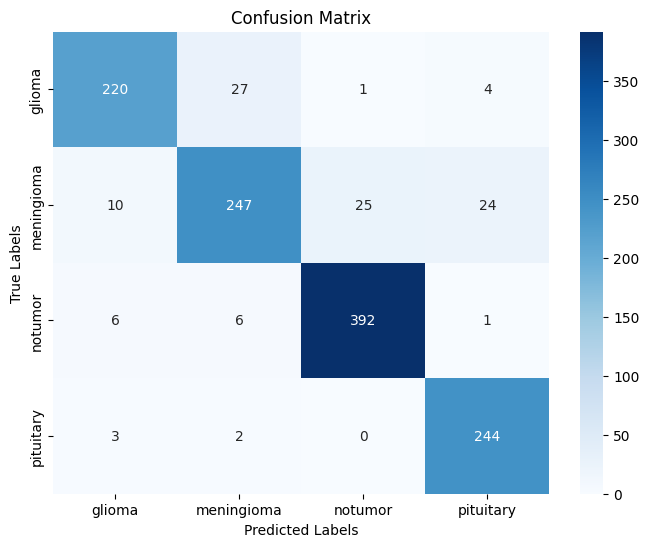

In [ ]:
#confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()